# Dynet tutorial: Visualizing the Mandelbrot fractal

Here's a simple dynet program to get familiarized with some of the operations available by visualizing a fractal: the Mandelbrot set.

The Mandelbrot set is defined as the set of complex numbers $c$ for which the sequence defined as 

\begin{split}
z_0&=0\\
z_{n+1}&=z_{n}^2+c\\
\end{split}

is bounded. You can read more about it in the [wikipedia entry](https://en.wikipedia.org/wiki/Mandelbrot_set).

First a few imports. I'm using one of the latest versions of dynet, but any release >2.0.3 should do the trick

In [1]:
import numpy as np
import dynet as dy
# Plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

Let us declare all possible values of c we're testing for. We don't really need to bother with any $c$ such that $\vert c\vert>2$ because most of them will diverge at some points.

Dynet doesn't have built-in complex numbers so we're going to represent those as 2d vectors 

In [2]:
# Resolution for the visualization
N = 500
# x and y coordinates
x = np.linspace(-2.0, 1.0, N)
y = np.linspace(-1.5, 1.5, N)
# c values as a two lists of coordinates
c_vals = np.stack(np.meshgrid(x, y), axis=0).reshape(2,-1)

Next thing we need to do is to code a `square` operation for complex numbers (as 2d vectors). Dynet will handle batching automatically so we don't need to explicitly consider the case when the input is batched and can treat it as a single vector

In [3]:
def square(complex_number):
    """Square of a complex number (represented as a vector)"""
    # Retrieve real and imaginary part
    # z = a + bi
    a = complex_number[0] # This will pick the 1st sub-tensor along the 1st dimension
    b = complex_number[1]
    # z^2 = (a + bi)^2 = (a^2 - b^2) + (2ab)i
    a_2 = dy.square(a) - dy.square(b) # We can use the dy.square function for real numbers
    b_2 = 2*dy.cmult(a, b)            # We use dy.cmult for component-wise multiplication of reals
    # Return the result as a vector by concatenating
    return dy.concatenate([a_2, b_2])

Here comes the main loop. We're not doing any gradient descent here so there's not backward pass. Each iteration goes:
1. Call `dy.renew_cg()` to garbage-collect the computation graph
2. Add inputs to the computation graph with `dy.inputTensor`
3. Write all our operations (builds the computation graph)
4. Run the forward pass by calling `.npvalue()` on the output (all the computation is done here)
5. Rinse and repeat

In [4]:
# Number of iterations. Increasing this number will make the border of the fractal more accurate
# At our resolution, 25 is good enough
n_iterations=25
# Initial values z_0=0
z_vals = np.zeros(c_vals.shape)
# Keep track of whether each c value leads to divergence.
# The default value is set to 2 * n_iterations so that points that never diverge have the highest value by a margin 
diverged = np.zeros(c_vals.shape[-1]) + 2*n_iterations
# Now we start the iterative process of computing z_n
for iteration in range(n_iterations):
    # Don't forget to renew the computation graph
    dy.renew_cg()
    # Input the current value of z_n in the computation graph.
    # Notice the `batched=True` argument so that z is an expression of dimension 2 and batch size N*N
    # z.dim() will return ((2,), N*N)
    z = dy.inputTensor(z_vals, batched=True)
    # Input c in the computation graph, batched as well
    c = dy.inputTensor(c_vals, batched=True)
    # Do the update
    z = square(z) + c
    # compute z's module (l2 norm of the vector)
    z_mod = dy.l2_norm(z)
    # Retrieve the module value (runs the forward pass).
    # This returns an array of shape (1, N*N): the batch size is the last dimension
    z_mod_vals = z_mod.npvalue().flatten()
    # Check for divergence (if |z|>2 then the sequence diverges for sure)
    diverged[z_mod_vals > 2]=iteration
    # Update z_vals by retrieving the update from the computation graph
    # This will not rerun the forward pass as z was already computed for z_mod
    z_vals = z.npvalue()

/home/pmichel31415/.local/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


Plot the result!

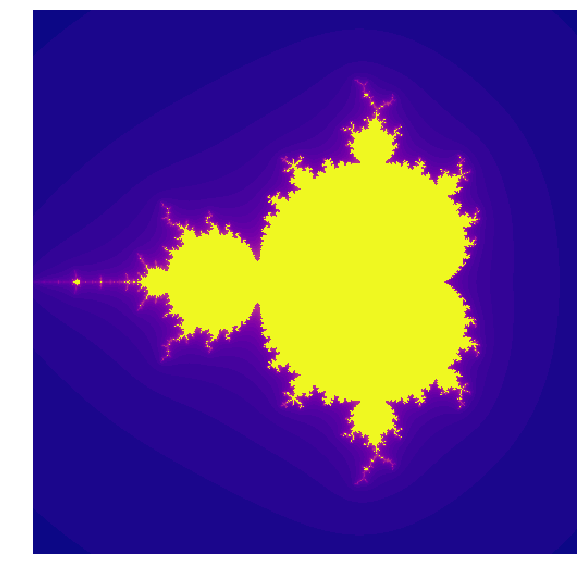

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(diverged.reshape((N,N)), cmap='plasma')
_ = plt.axis('off')